# `glenglat`: Global englacial temperature database

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mjacqu/glenglat/blob/main/tutorial.ipynb)

Python notebook illustrating how to load and navigate the `glenglat` dataset using Python.

## Initialize the environment

Import the Python libraries that will be needed later.

In [ ]:
# Import standard libraries
from collections import defaultdict
import json
from pathlib import Path
import re

# Import third party libraries
import geopandas as gpd
import networkx
import numpy as np
import pandas as pd
import plotnine as p9

# Ignore distracting warnings
import warnings
warnings.filterwarnings('ignore')

Download a published version of glenglat from [Zenodo](https://sandbox.zenodo.org/records/99520) and unzip the file.

In [ ]:
!wget --no-clobber --output-document=glenglat.zip https://zenodo.org/records/15005624/files/glenglat-v1.0.0.zip
!unzip -n glenglat.zip

## Load the data

The four tables `source`, `borehole`, `profile`, and `measurement` are stored as comma-separated values (CSV) files in the `data` folder. Since the `profile.csv` and `measurement.csv` files for a few boreholes with many profiles are stored separately in subfolders, to read all the data we concatenate tables with the same name to end up with one [`pandas`](https://pandas.pydata.org/) (pd) [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) (df) for each table.

Although optional, we use the column data types defined in the metadata file (`datapackage.json`) to ensure that the data is read correctly.

In [ ]:
# Convert column data types in metadata to Pandas format
pandas_dtypes = {
  'string': 'string',
  'number': 'Float64',
  'integer': 'Int64',
  'boolean': 'boolean',
  'time': 'string',
  'year': 'Int64'
}

# Extract column data types from the metadata
# (in the metadata, table = resource and column = field)
metadata = json.loads(Path('datapackage.json').read_text())
table_dtypes = defaultdict(dict)
table_dates = defaultdict(list)
for resource in metadata['resources']:
  table_name = resource['name']
  for field in resource['schema']['fields']:
    if field['type'] == 'date':
      table_dates[table_name] += [field['name']]
    else:
      table_dtypes[table_name][field['name']] = pandas_dtypes[field['type']]

# Read
dfs = {}
for path in Path('data').glob('**/*.csv'):
  # Read table name from file name (data/source.csv -> source)
  table_name = path.stem
  # Read table from file
  table = pd.read_csv(
    path, dtype=table_dtypes[table_name], parse_dates=table_dates[table_name]
  )
  # Build a list of all tables with the same name
  if table_name not in dfs:
    dfs[table_name] = []
  dfs[table_name] += [table]
for table_name, tables in dfs.items():
  # Concatenate tables with the same name
  dfs[table_name] = pd.concat(tables, ignore_index=True)

Alternatively, the same could be achieved more simply (but more slowly) using the [`frictionless`](https://framework.frictionlessdata.io/) library.

In [ ]:
# !pip install frictionless
# import frictionless

# package = frictionless.Package('datapackage.json')
# dfs = {
#     resource.name: resource.to_pandas().reset_index().convert_dtypes()
#     for resource in package.resources
#   }

Now we can access each of our four tables by name, for example `borehole`.

In [ ]:
dfs['borehole']

,id,source_id,glacier_name,glims_id,location_origin,latitude,longitude,elevation_origin,elevation,mass_balance_area,...,date_max,drill_method,ice_depth,depth,to_bed,temperature_uncertainty,notes,curator,investigators,funding
0,1,haeberli1991,Grenzgletscher,G007908E45948N,published,45.930329,7.875013,published,4450.0,accumulation,...,1977-08-20,mechanical,<NA>,50.0,False,<NA>,location_origin: 1 m from borehole 783 | date_...,Ethan Welty,(Universität Bern),<NA>
1,2,blatter1984,Grenzgletscher,G007800E45965N,estimated,45.967331,7.797442,published,2600.0,ablation,...,1979-12-31,<NA>,<NA>,<NA>,False,<NA>,location_origin: elevation and '5 km from term...,Mylène Jacquemart | Guillem Carcanade,<NA>,<NA>
2,3,blatter1984,Grenzgletscher,G007800E45965N,estimated,45.973722,7.763328,published,2500.0,ablation,...,1980-12-31,<NA>,<NA>,<NA>,False,<NA>,location_origin: elevation and '2 km from term...,Mylène Jacquemart | Guillem Carcanade,<NA>,<NA>
3,4,blatter1985,White Glacier,G269329E79672N,estimated,79.53078,-91.00176,published,1447.0,accumulation,...,1979-07-13,thermal,<NA>,268.0,False,0.2,location_origin: Converted local coordinates i...,Ethan Welty,<NA>,<NA>
4,5,blatter1985,White Glacier,G269329E79672N,estimated,79.47207,-90.75663,published,625.0,ablation,...,1980-05-20,thermal,<NA>,320.0,True,0.2,location_origin: Converted local coordinates i...,Ethan Welty,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,808,dolgushin1961,Karabatak Glacier,G078269E42140N,guessed,42.148707,78.271542,published,3460.0,<NA>,...,1948-05-01,<NA>,<NA>,<NA>,<NA>,<NA>,location_origin: Based on range name ('central...,Ethan Welty,<NA>,<NA>
744,809,huang1982,乌鲁木齐河源1号冰川 [Urumqi River No. 1 Glacier],G086810E43111N,guessed,43.115474,86.813833,published,3825.0,ablation,...,1962-06-01,<NA>,<NA>,4.0,<NA>,<NA>,location_origin: Based on glacier name and ele...,Ethan Welty,<NA>,<NA>
745,810,huang1982,乌鲁木齐河源1号冰川 [Urumqi River No. 1 Glacier],G086810E43111N,guessed,43.114961,86.813298,published,3845.0,ablation,...,1964-11-01,<NA>,<NA>,10.0,<NA>,<NA>,location_origin: Based on glacier name and ele...,Ethan Welty,(天山冰川站 [Tianshan Glacier Station]),<NA>
746,811,liu1988,Urumqi Glacier No. 1,G086801E43117N,guessed,43.1191,86.8085,published,3967.0,<NA>,...,1987-06-16,<NA>,<NA>,<NA>,<NA>,<NA>,location_origin: Assumed same as borehole 379 ...,Ethan Welty,<NA>,<NA>


## Compute derived columns

These additional columns are not present in the original dataset, but will be helpful in the sections that follow.

### Profile measurement year (`profile.year`)

Since the measurement date is not always known precisely, we use the year of the mean date between `date_min` and `date_max`.

In [ ]:
df = dfs['profile']
date_mean = df['date_min'] + (df['date_max'] - df['date_min']) / 2
df['year'] = date_mean.dt.year.astype('Int64')

### Borehole measurement depth (`borehole.measurement_depth`)

The maximum depth to which temperature was measured in each borehole.

In [ ]:
df = dfs['borehole'].set_index('id')
df['measurement_depth'] = dfs['measurement'].groupby('borehole_id')['depth'].max()
dfs['borehole'] = df.reset_index()

### Glacier identifier (`borehole.glacier_id`)

We assign a `glacier_id` based on the [Global Land Ice Measurements from Space (GLIMS)](https://www.glims.org) glacier identifier (`glims_id`) or, for the few cases where this is not available, the glacier name (`glacier_name`).

In [ ]:
df = dfs['borehole']
df['glacier_id'] = df['glims_id'].combine_first(df['glacier_name'])

### Region identifier (`borehole.region_id`)

We assign boreholes to their corresponding GTN-G Glacier Region (https://doi.org/10.5904/gtng-glacreg-2023-07) based on their coordinates (`latitude`, `longitude`). In the process, we upgrade the `borehole` table to a [`geopandas`](https://geopandas.org) [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html).

In [ ]:
# Load GTN-G Glacier Regions
regions = gpd.read_file('https://www.gtn-g.ch/database/GlacReg_2023.zip')

# Upgrade borehole table to GeoDataFrame
df = dfs['borehole']
geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs=4326)
dfs['borehole'] = gpd.GeoDataFrame(df, geometry=geometry)

# Assign region.long_code to borehole.region_id
gdf = dfs['borehole']
indices = gdf.sindex.query(regions.geometry, predicate='contains')
gdf['region_id'] = pd.NA
gdf['region_id'].iloc[indices[1]] = regions['long_code'].iloc[indices[0]]

# Preview result
dfs['borehole'][['id', 'glacier_name', 'region_id']]

,id,glacier_name,region_id
0,1,Grenzgletscher,11_central_europe
1,2,Grenzgletscher,11_central_europe
2,3,Grenzgletscher,11_central_europe
3,4,White Glacier,03_arctic_canada_north
4,5,White Glacier,03_arctic_canada_north
...,...,...,...
743,808,Karabatak Glacier,13_central_asia
744,809,乌鲁木齐河源1号冰川 [Urumqi River No. 1 Glacier],13_central_asia
745,810,乌鲁木齐河源1号冰川 [Urumqi River No. 1 Glacier],13_central_asia
746,811,Urumqi Glacier No. 1,13_central_asia


### Borehole temperature at 15 m depth (`borehole.temperature_15m`)

To compare their thermal regimes, it is useful to estimate a mean temperature for all boreholes at a fixed depth. A depth of 15 m is a good choice: deep enough to avoid the near-surface temperature fluctuations but not so deep as to exclude many shallower boreholes.

In [ ]:
depth = 15  # m

# Extract measurements for profiles that are equilibrated (or not specified)
equilibrated_or_unknown = (
  dfs['profile']['equilibrium'].isin(['true', 'estimated']) |
  dfs['profile']['equilibrium'].isnull()
)
profile_ids = dfs['profile']['id'][equilibrated_or_unknown]
selected = dfs['measurement']['profile_id'].isin(profile_ids)
df = dfs['measurement'][selected]

# Reduce each profile to mean temperature in 1 m depth bins
df['depth_bin'] = df['depth'].astype(int)
df = df.groupby(['borehole_id', 'profile_id', 'depth_bin'])['temperature'].mean()

# Reduce repeat profiles to mean temperature in each depth bin
df = df.droplevel('profile_id').groupby(level=['borehole_id', 'depth_bin']).mean()

# Interpolate mean profiles at fixed depth
interpolate_profile = lambda gdf: np.interp(
  x=depth, xp=gdf['depth_bin'], fp=gdf['temperature'], left=np.nan, right=np.nan
)
depth_temperature = df.reset_index().groupby('borehole_id').apply(interpolate_profile)

# Assign temperature to boreholes
df = dfs['borehole'].set_index('id')
df['temperature_15m'] = depth_temperature
dfs['borehole'] = df.reset_index()

## Plot boreholes on a map

Let's begin by making a world map of all boreholes. We will use [`geopandas`](https://geopandas.org/) to load country outlines and
[`plotnine`](https://plotnine.org) - inspired by R's [`ggplot2`](https://ggplot2.tidyverse.org/) - for plotting.

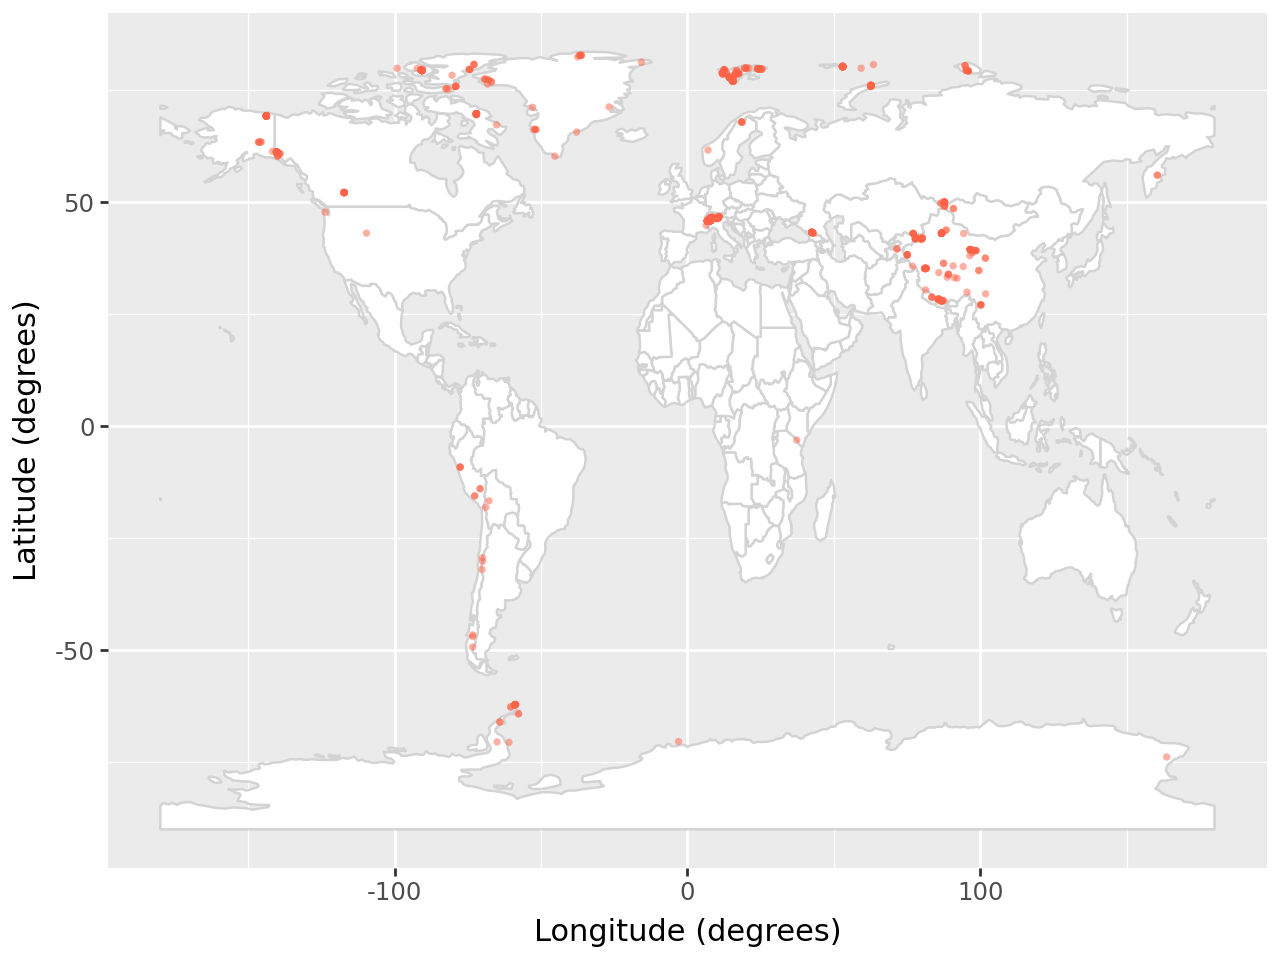

In [ ]:
countries = gpd.read_file(
  'https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip'
)

(p9.ggplot(data=countries)
  + p9.geom_map(fill='white', color='lightgrey')
  + p9.geom_map(
      data=dfs['borehole'],
      fill='tomato',
      color='none',
      alpha=0.5,
      size=1
    )
  + p9.labs(x='Longitude (degrees)', y='Latitude (degrees)')
)

## Plot temperature profiles

We select boreholes by their `id` and plot all of their temperature profiles. Boreholes with many repeated measurements are chosen to highlight the seasonal fluctuations in temperature near the surface.

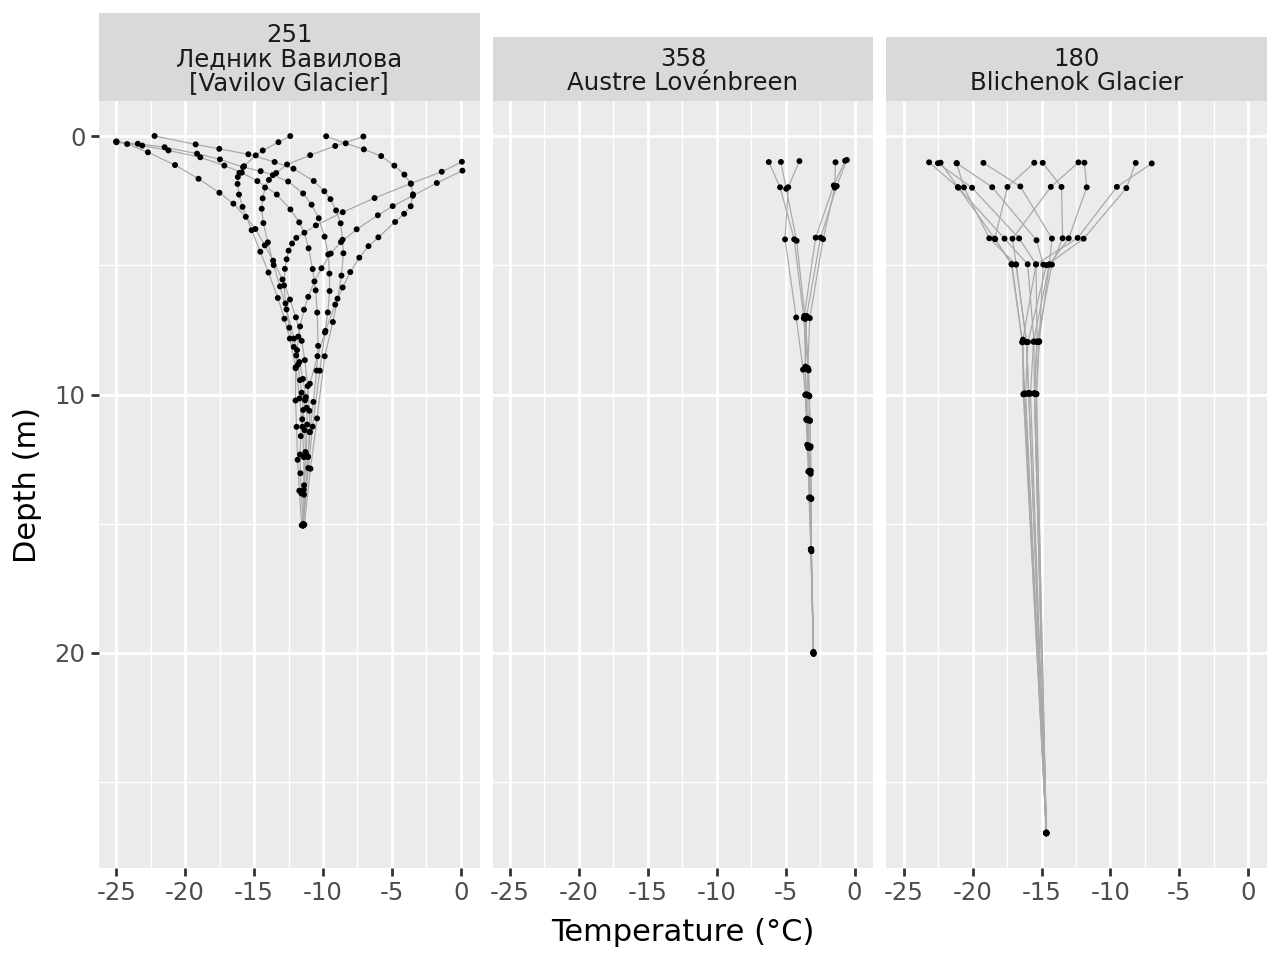

In [ ]:
# Select which boreholes' profiles to plot
borehole_ids = [
  251,  # Ледник Вавилова [Vavilov Glacier]
  358,  # Austre Lovénbreen
  180,  # Ледник Бильченок [Blichenok Glacier]
]

# Extract the profiles of the selected boreholes
df = dfs['measurement']
mask = df['borehole_id'].isin(borehole_ids)
profiles = df[mask]

# Add glacier name from borehole.glacier_name
glacier_name_by_id = dfs['borehole'].set_index('id')['glacier_name']
profiles['glacier_name'] = glacier_name_by_id.loc[profiles['borehole_id']].values

# Enforce borehole display order
profiles['borehole_id'] = pd.Categorical(
  values=profiles['borehole_id'], categories=borehole_ids
)

# Plot
mapping = p9.aes(
  x='temperature',
  y='depth',
  # Uniquely identify each profile as '{borehole_id}.{profile_id}'
  group='borehole_id.astype(str) + "." + profile_id.astype(str)'
)
(p9.ggplot(profiles, mapping)
  + p9.geom_path(size=0.25, color='darkgrey')
  + p9.geom_point(size=0.2, color='black')
  + p9.scales.scale_y_reverse()
  + p9.labs(x='Temperature (°C)', y='Depth (m)')
  + p9.facet_grid(
      '. ~ borehole_id + glacier_name',
      labeller=lambda label: label.replace(' [', '\n[')
    )
)

We select boreholes by their id, classify each (manually) as being in the accumulation or ablation area of the glacier, and plot their first temperature profile. Boreholes are chosen to highlight the variety of glacier thermal regimes.

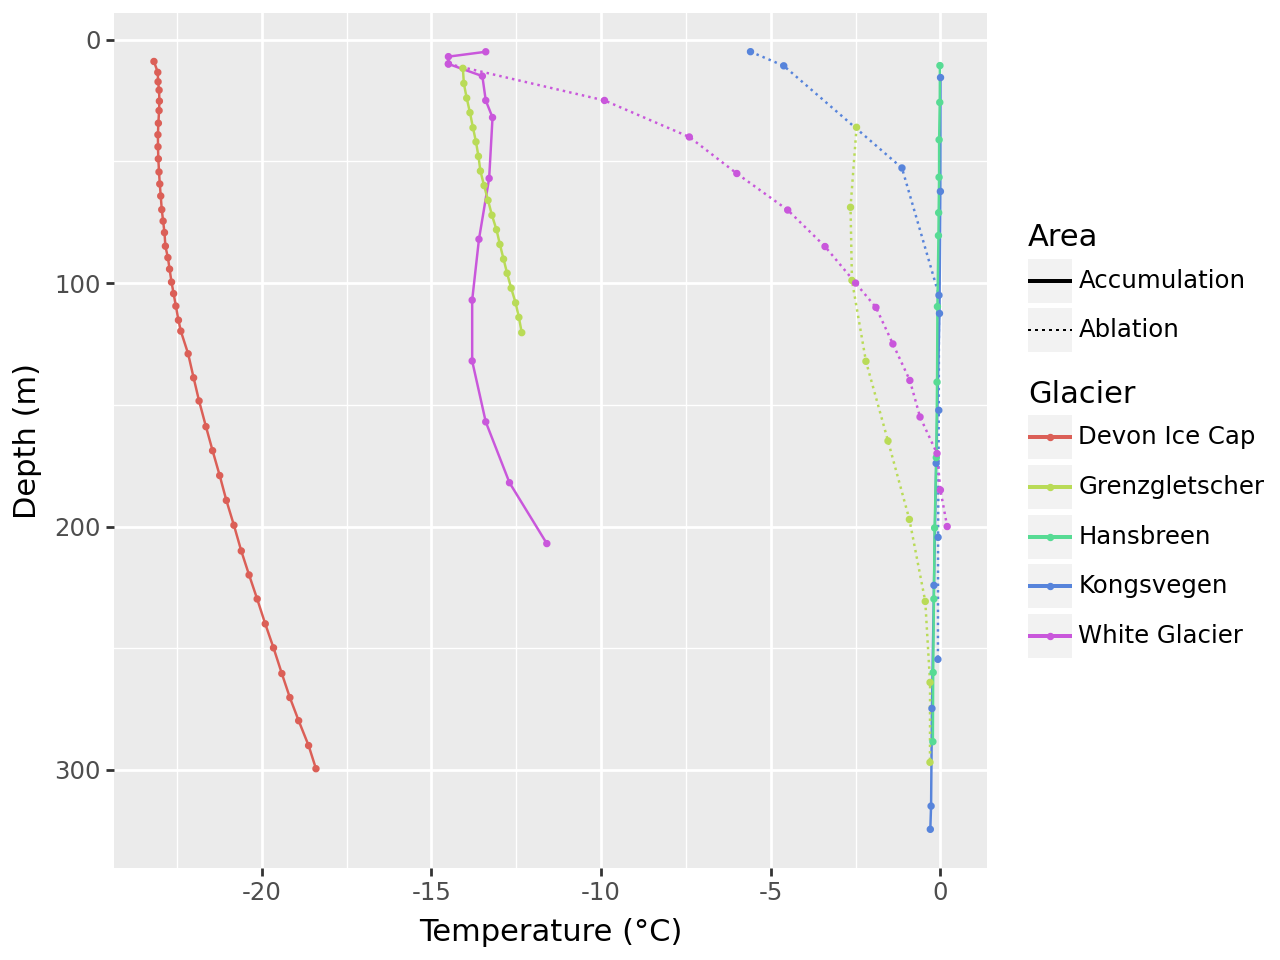

In [ ]:
# Classify boreholes as located in accumulation or ablation area
borehole_area = {
  235: 'Accumulation',  # Devon Ice Cap
  264: 'Accumulation',  # White Glacier
  267: 'Ablation',  # White Glacier
  273: 'Accumulation',  # Grenzgletscher
  177: 'Ablation',  # Grenzgletscher
  41: 'Accumulation',  # Kongsvegen
  40: 'Ablation',  # Kongsvegen
  109: 'Accumulation'  # Hansbreen
}

# Extract the first profiles of the selected boreholes
df = dfs['measurement']
mask = df['borehole_id'].isin(borehole_area) & df['profile_id'].eq(1)
profiles = df[mask]

# Add glacier name from borehole.glacier_name
glacier_name_by_id = dfs['borehole'].set_index('id')['glacier_name']
profiles['glacier_name'] = glacier_name_by_id.loc[profiles['borehole_id']].values

# Add glacier area from above and set display order: Accumulation, Ablation
profiles['area'] = pd.Categorical(
  values=profiles['borehole_id'].map(borehole_area),
  categories=['Accumulation', 'Ablation']
)

# Plot
mapping = p9.aes(
  x='temperature',
  y='depth',
  color='glacier_name',
  linetype='area',
  group='borehole_id'
)
(p9.ggplot(profiles, mapping)
  + p9.geom_path()
  + p9.geom_point(size=0.5)
  + p9.scale_linetype_manual(values=['solid', 'dotted'])
  + p9.scales.scale_y_reverse()
  + p9.labs(x='Temperature (°C)', y='Depth (m)', color='Glacier', linetype='Area')
)

## Compare regional statistics

Using `region_id`, we can summarize borehole statistics by region.

In [ ]:
dfs['borehole'].groupby('region_id').agg(**{
  'glacier_count': ('glacier_id', 'nunique'),
  'borehole_count': ('region_id', 'size'),
  'borehole_count_15m': ('measurement_depth', lambda x: x.ge(15).sum())
}).astype('Int64')

,glacier_count,borehole_count,borehole_count_15m
region_id,,,
01_alaska,11,59,31
02_western_canada_usa,3,15,4
03_arctic_canada_north,10,67,56
04_arctic_canada_south,4,17,17
05_greenland_periphery,14,24,5
07_svalbard_jan_mayen,30,80,51
08_scandinavia,2,5,5
09_russian_arctic,13,61,19
10_north_asia,10,22,10


Regional distributions of numeric attributes, such as borehole elevation, measurement depth, and 15 m temperature are best compared graphically.

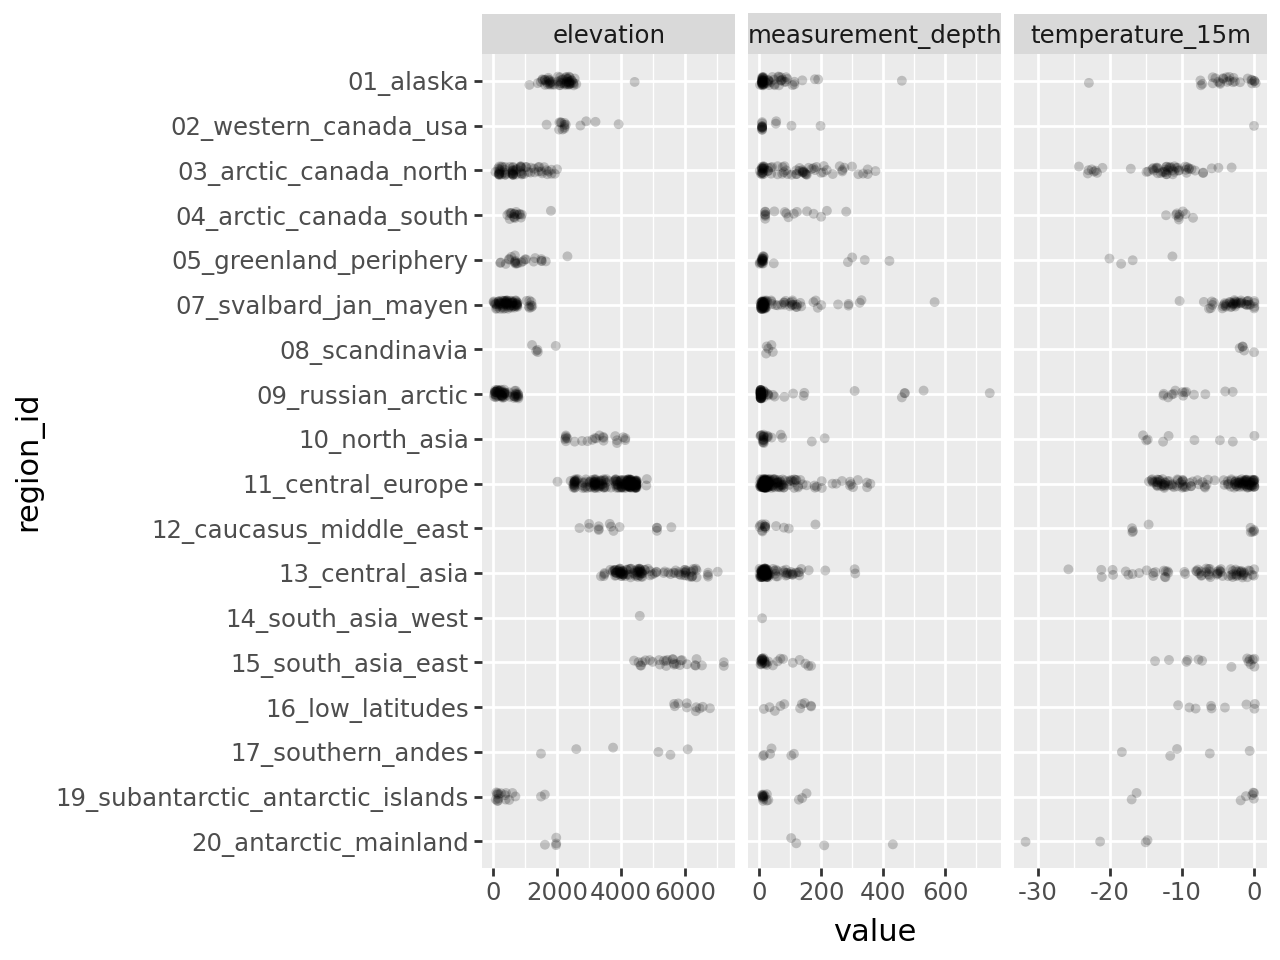

In [ ]:
variables = ['measurement_depth', 'elevation', 'temperature_15m']

# Melt from wide to long format for plotting
df = dfs['borehole'].melt(
  id_vars=['region_id'],
  value_vars=variables,
  var_name='variable',
  value_name='value'
).astype({'value': 'float64'})

# Set region display order
df['region_id'] = pd.Categorical(
  values=df['region_id'],
  categories=df['region_id'].drop_duplicates().sort_values(ascending=False)
)

# Plot
(
  p9.ggplot(df, p9.aes(x='region_id', y='value'))
  + p9.geom_jitter(height=0, width=0.1, alpha=0.2, stroke=0, size=2)
  + p9.coord_flip()
  + p9.facet_grid('. ~ variable', scales='free')
)

## Plot measurement timelines

We plot a histogram of the number of boreholes measured each year.

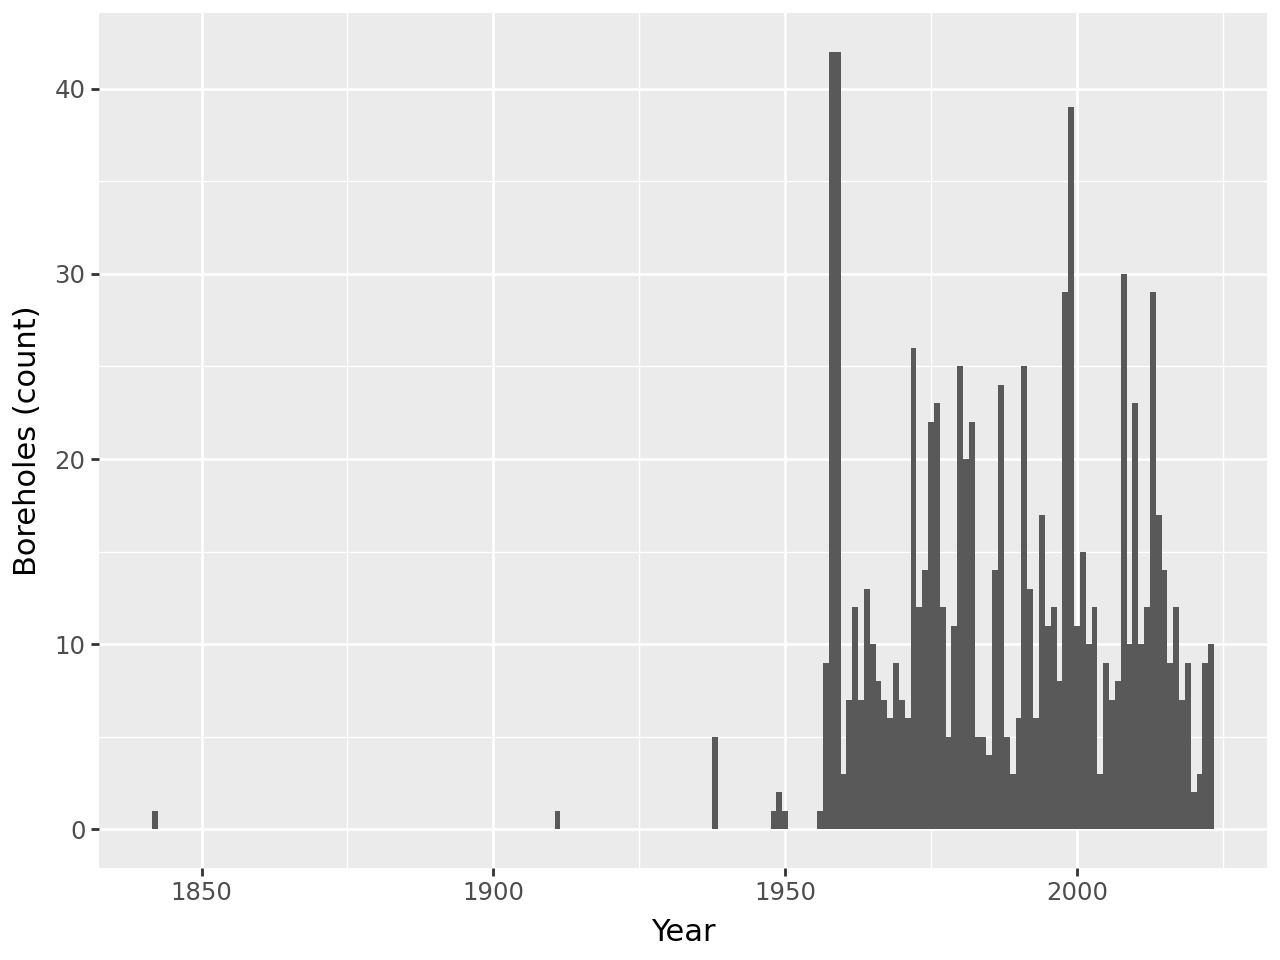

In [ ]:
each_borehole_year = dfs['profile'][['borehole_id', 'year']].drop_duplicates()

(p9.ggplot(each_borehole_year, p9.aes(x='year'))
  + p9.geom_histogram(binwidth=1)
  + p9.labs(x='Year', y='Boreholes (count)')
)

Alternatively, we can plot the number of glaciers measured each year.

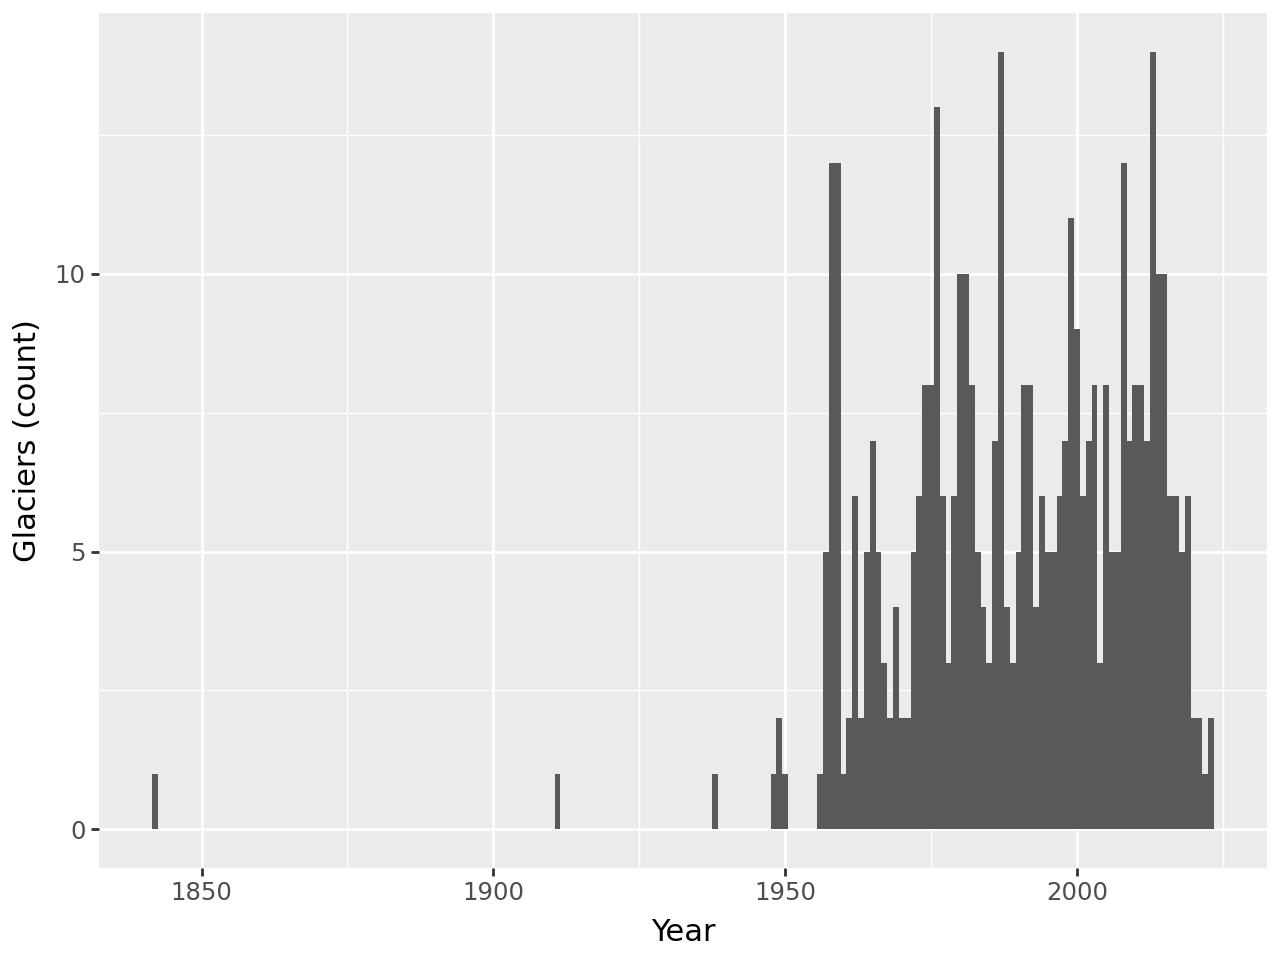

In [ ]:
df = dfs['profile'].merge(dfs['borehole'], left_on='borehole_id', right_on='id')
each_glacier_year = df[['glacier_id', 'year']].drop_duplicates()

(p9.ggplot(each_glacier_year, p9.aes(x='year'))
  + p9.geom_histogram(binwidth=1)
  + p9.labs(x='Year', y='Glaciers (count)')
)

## Summarize data sources

All of the sources of primary (temperature versus depth) and secondary (e.g. borehole elevation) data are referenced in the `source` table and can be explored in the same way as the data in the other tables.

Submissions: 11
Literature: 284
Literature (primary): 190
Literature (secondary): 94
Literature (non-English): 70 (25%)
Literature before 1990 (non-English): 44 (44%)


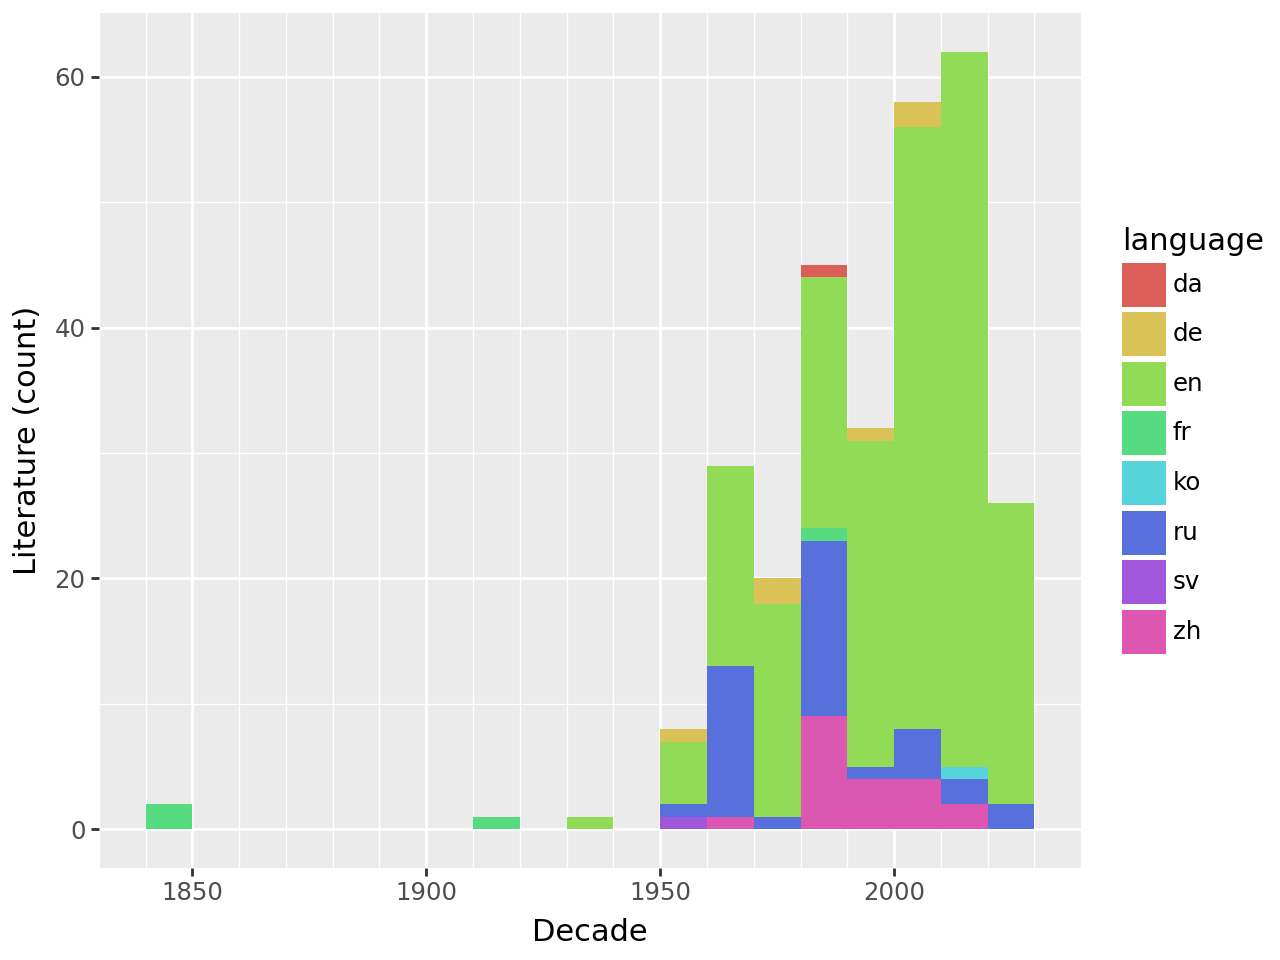

In [ ]:
df = dfs['source']

# Type
is_submission = df['type'].eq('personal-communication')
is_primary_source = df['id'].isin(dfs['profile']['source_id'])
print(
  'Submissions:',
  is_submission.sum()
)
print(
  'Literature:',
  (~is_submission).sum()
)
print(
  'Literature (primary):',
  (is_primary_source & ~is_submission).sum()
)
print(
  'Literature (secondary):',
  (~is_primary_source & ~is_submission).sum()
)

# Language
is_english = df['language'].eq('en')
print(
  'Literature (non-English):',
  (~is_english & ~is_submission).sum(),
  f'({(~is_english & ~is_submission).sum() / (~is_submission).sum():.0%})'
)
is_early = df['year'].lt(1990)
print(
  'Literature before 1990 (non-English):',
  (~is_english & ~is_submission & is_early).sum(),
  f'({(~is_english & ~is_submission & is_early).sum() / (~is_submission & is_early).sum():.0%})'
)

# Year and language by decade
(
  p9.ggplot(df[~is_submission], p9.aes(x='year', fill='language'))
  + p9.geom_histogram(binwidth=10, boundary=0)
  + p9.scale_x_continuous(
    minor_breaks=lambda limits: range(
      round(limits[0] / 10) * 10, round(limits[1] / 10) * 10 + 10, 10
    )
  )
  + p9.labs(x='Decade', y='Literature (count)')
)

## Summarize the work done on each glacier

Say we want to build a human-friendly table summarizing all englacial temperature measurements, providing - for each glacier in a region - the number of boreholes and a list of all sources.

### Define "glacier" (`borehole.glacier_group_id`)

First, what do we mean by "glacier"? We could use the `glacier_id` computed earlier to count glaciers (based on `glims_id`), but glaciers that we colloquially refer to as a single glacier may have multiple GLIMS ids (e.g. the drainage basins of Lomonosovfonna ice cap). Nor can we rely on `glacier_name` alone, because a glacier may have many names (e.g. Lomonosovfonna, Ледниковое Плато Ломоносова).

A programmatic solution, which assumes that different glaciers in the data do not have the same name (true now but may not always be), is to build a network graph of (`glims_id`, `glacier_name`) pairs and group connected pairs together as the same glacier.

In [ ]:
df = dfs['borehole'].set_index('id')

# Build undirected network graph from pairs of (glims_id, glacier_name)
graph = networkx.Graph()
pairs = df[['glims_id', 'glacier_name']].drop_duplicates()
# For boreholes without a GLIMS id, use the glacier name
pairs['glims_id'] = pairs['glims_id'].combine_first(pairs['glacier_name'])
graph.add_edges_from(pairs.itertuples(index=False, name=None))

# Map glims_id/glacier_name values to group ids
value_to_group_id = {}
for group_id, values in enumerate(networkx.connected_components(graph)):
  value_to_group_id.update({value: group_id for value in values})

# Assign boreholes to a glacier_group_id
df['glacier_group_id'] = df['glims_id'].map(value_to_group_id).combine_first(
  df['glacier_name'].map(value_to_group_id)
).astype(int)
dfs['borehole'] = df.reset_index()

# Confirm that no glaciers in a different region share a group
assert not dfs['borehole'].groupby('glacier_group_id')['region_id'].nunique().gt(1).any()

### Extract all borehole sources (`borehole.source_ids`)

Sources are referenced explicitly by their `id` (e.g. blatter1985) in columns `borehole_source_id` and `profile_source_id`, but also in `borehole.notes` and `profile.notes`. We can extract source ids from text using a [regular expression](https://docs.python.org/3/howto/regex.html).

In [ ]:
# Regular expression (regex) to match source id within text
source_id_regex = r'(?:^|\s|\()([a-z]+[0-9]{4}[a-z]?)(?:$|\s|\)|,|\.)'

# Extract all source ids for each borehole
source_ids_by_borehole_id = (
  # borehole.source_id
  dfs['borehole'].groupby('id')['source_id'].agg(list)
) + (
  # profile.source_id
  dfs['profile'].groupby('borehole_id')['source_id'].agg(list)
) + (
  # borehole.notes
  dfs['borehole'].set_index('id')['notes']
  .str.extractall(source_id_regex)[0]
  .groupby(level='id')
  .agg(list)
  .reindex(dfs['borehole']['id'], fill_value=[])
) + (
  # profile.notes
  dfs['profile'].set_index('borehole_id')['notes']
  .str.extractall(source_id_regex)[0]
  .groupby(level='borehole_id')
  .agg(list)
  .reindex(dfs['borehole']['id'], fill_value=[])
)

# Assign source ids to boreholes
df = dfs['borehole'].set_index('id')
df['source_ids'] = source_ids_by_borehole_id.apply(set)
dfs['borehole'] = df.reset_index()

### Tabulate by glacier

Finally we are ready to build our desired table. We parse source ids into their component parts in order to sort them by year, then author name, then (if present) suffix.

In [ ]:
# Regular expression to parse source id parts
source_id_parts_regex = r'^(?P<name>[a-z]+)(?P<year>[0-9]{4})(?P<suffix>[a-z]?)$'

def source_id_sort_key(source_id: str) -> tuple:
  """Sort key for source ids: year, name, suffix."""
  parts = re.match(source_id_parts_regex, source_id).groups()
  return parts[1], parts[0], parts[2]

# Tabulate by glacier
dfs['borehole'].groupby(['region_id', 'glacier_group_id']).agg(**{
  'glacier_names': ('glacier_name', lambda x: ', '.join(x.dropna().drop_duplicates())),
  'glims_ids': ('glims_id', lambda x: ', '.join(x.dropna().drop_duplicates())),
  'borehole_count': ('id', 'nunique'),
  'source_ids': (
    'source_ids',
    lambda x: ', '.join(sorted(set.union(*x), key=source_id_sort_key))
  )
}).droplevel('glacier_group_id').sort_values(['region_id', 'glacier_names'])

,glacier_names,glims_ids,borehole_count,source_ids
region_id,,,,
01_alaska,Black Rapids Glacier,G213683E63392N,3,harrison1975
01_alaska,Fox Glacier,G219698E61200N,6,classen1970
01_alaska,Jarvis Glacier,G214333E63481N,2,"lee2019, lee2020"
01_alaska,Little Kluane Glacier,G220578E60873N,1,flowers2022
01_alaska,McCall Glacier,G216152E69302N,27,"orvig1963, trabant1975, rabus2002, weller2007,..."
...,...,...,...,...
19_subantarctic_antarctic_islands,King George Island Ice Cap,G301226E62159S,1,ren1990
19_subantarctic_antarctic_islands,Nelson Island Ice Cap,"G301002E62274S, G300887E62269S",3,ren1990
20_antarctic_mainland,Bruce Plateau,G295982E66134S,2,zagorodnov2012
